In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [35]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [37]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


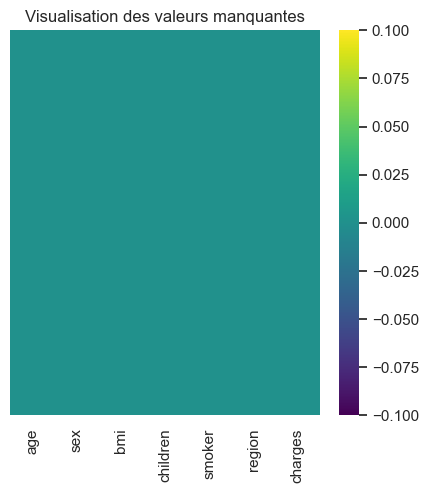

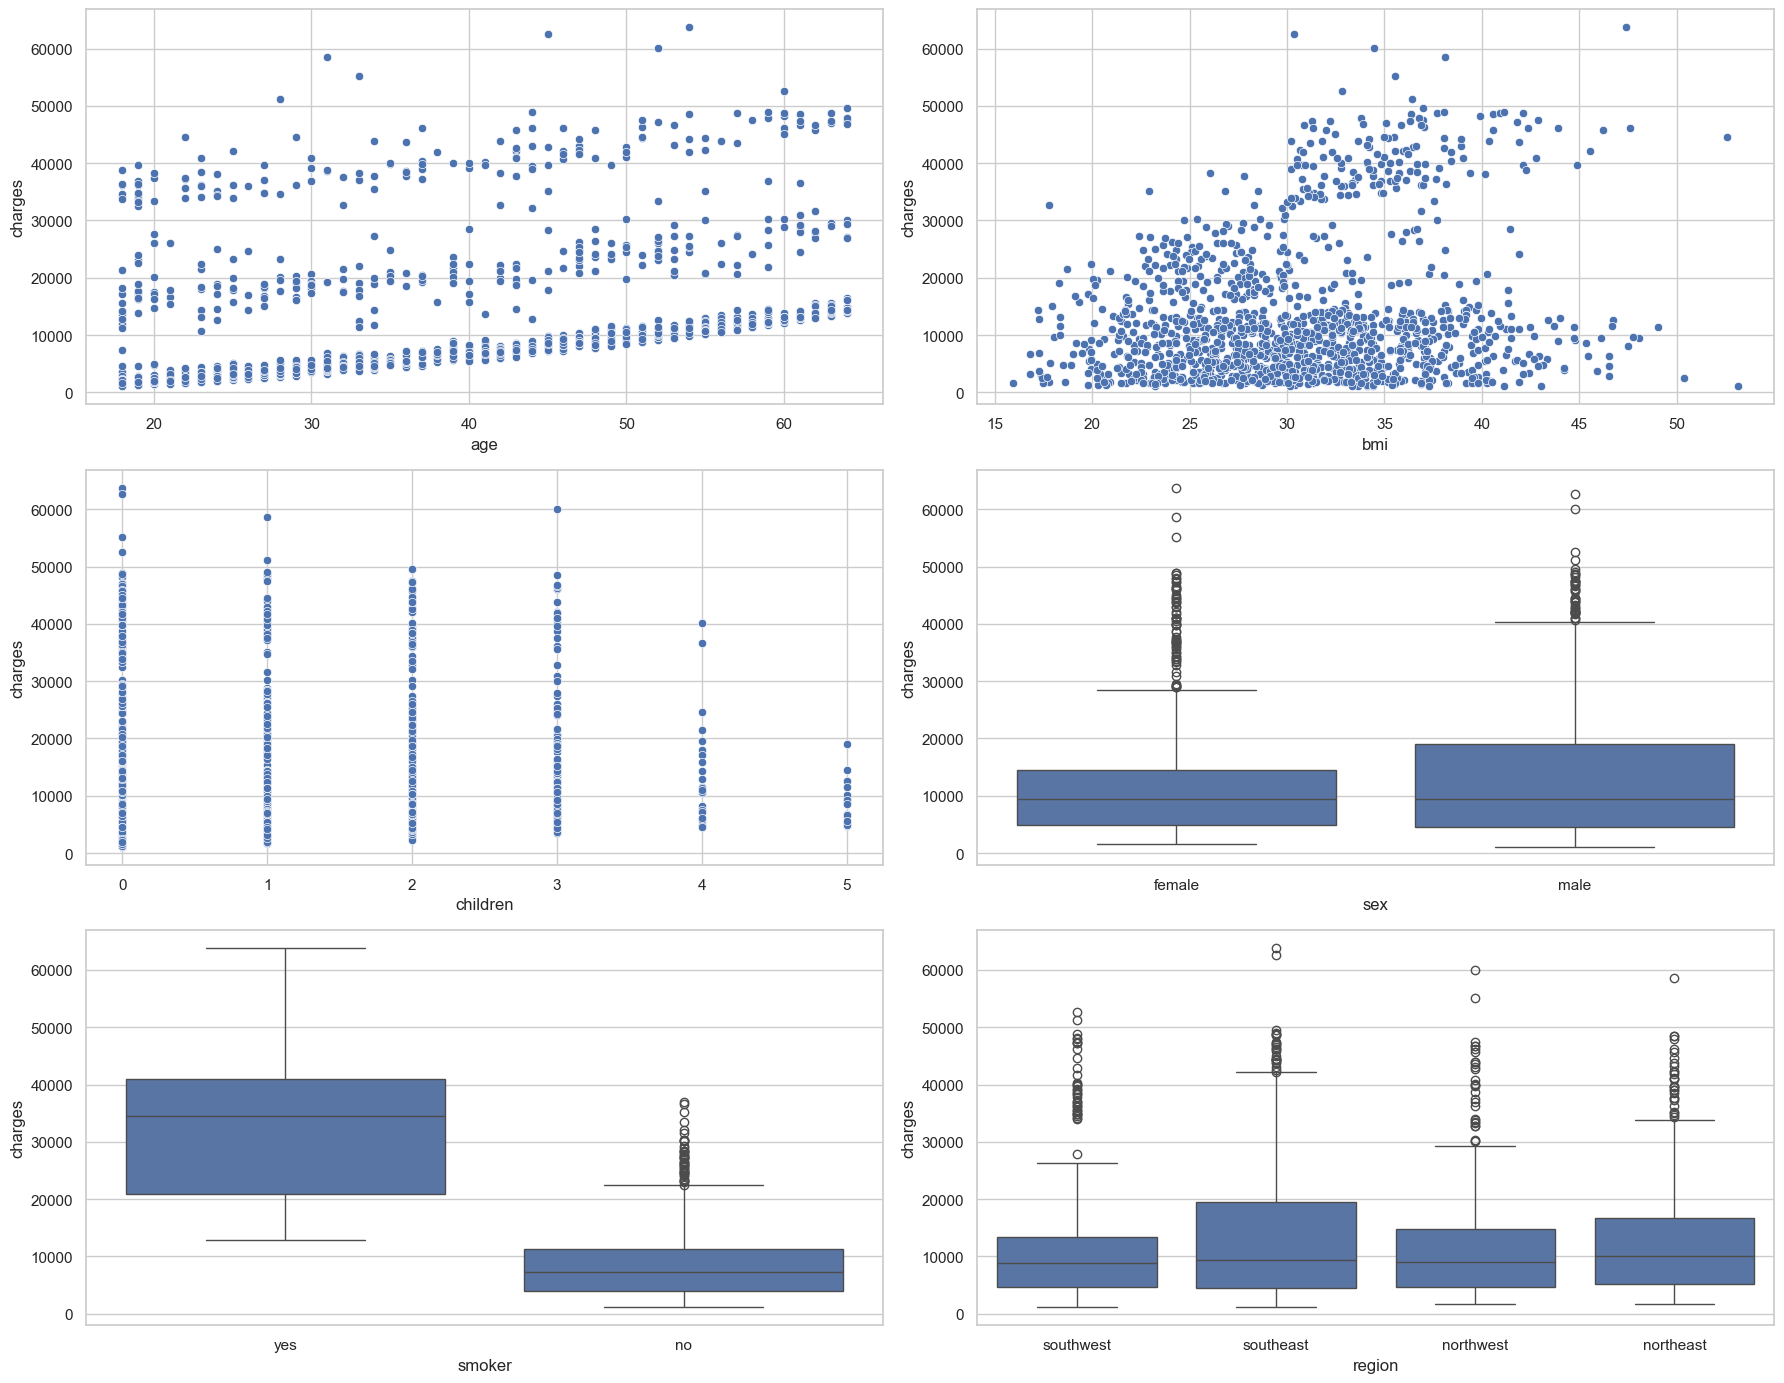

In [38]:
# Vérifier les valeurs manquantes
missing_values = data.isnull()

# Créer une heatmap pour visualiser les valeurs manquantes
plt.figure(figsize=(5, 5))
sns.heatmap(missing_values, cbar=True, cmap='viridis', yticklabels=False)

# Ajouter un titre au graphique
plt.title('Visualisation des valeurs manquantes')
plt.show()

variables = ['age', 'bmi', 'children', 'sex', 'smoker', 'region']
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for i, var in enumerate(variables):
    if data[var].dtype == 'object':
        sns.boxplot(x=data[var], y=data['charges'], ax=axes[i])
    else:
        sns.scatterplot(x=data[var], y=data['charges'], ax=axes[i])

plt.tight_layout()
plt.show()

In [39]:
# Paramètres généraux de style
sns.set(style="whitegrid")

# Diagramme en secteurs pour les variables catégorielles
def plot_pie(column, colors=None):
    plt.figure(figsize=(6, 6))
    counts = data[column].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.0f%%', startangle=90, colors=colors)
    plt.title(f"Répartition de '{column}'")
    plt.axis('equal')
    plt.show()



In [40]:
# Histogramme pour les variables numériques
def plot_hist(column, bins=20, color='#0099cc'):
    plt.figure(figsize=(8, 5))
    sns.histplot(data[column], bins=bins, kde=False, color=color)
    plt.title(f"Distribution de '{column}'")
    plt.xlabel(column)
    plt.ylabel("Nombre d'individus")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

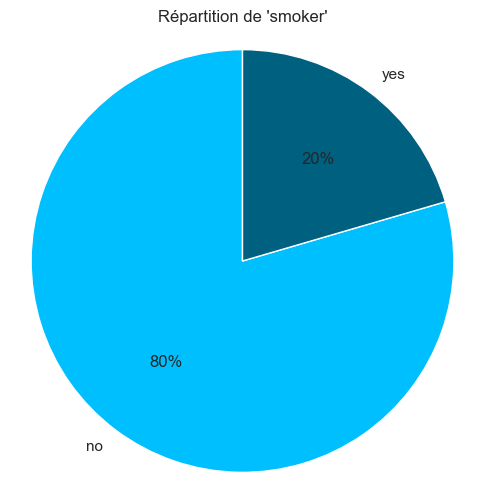

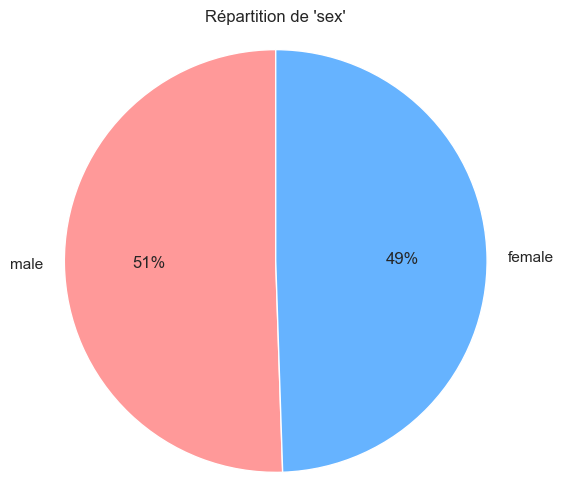

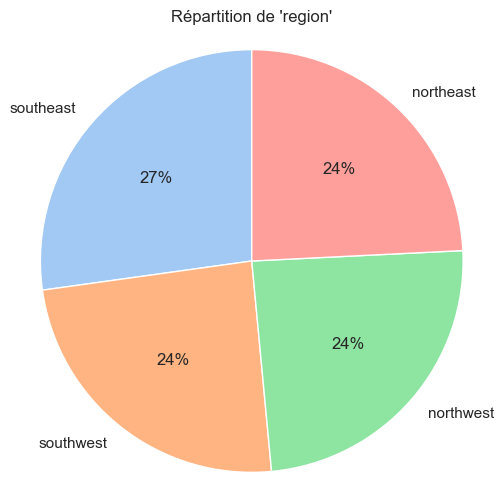

In [41]:
# 1. Catégorielles : smoker, sex, region
plot_pie('smoker', colors=['#00bfff', '#006080'])
plot_pie('sex', colors=['#ff9999', '#66b3ff'])
plot_pie('region', colors=sns.color_palette('pastel')[0:4])


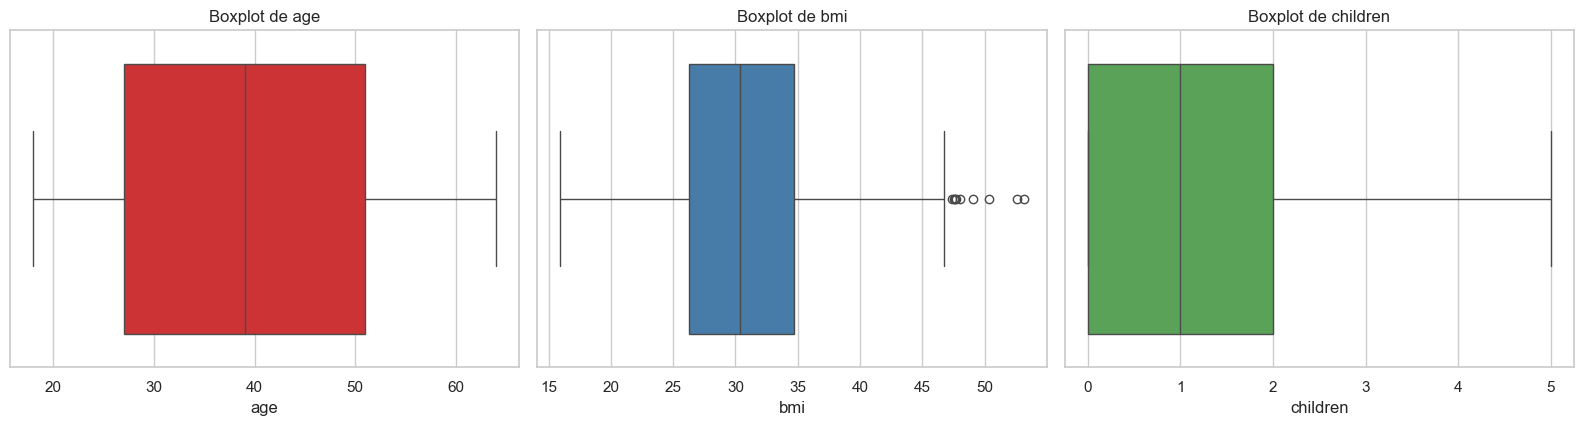

In [42]:
# Colonnes à tracer
columns = ['age', 'bmi', 'children']

# Générer autant de couleurs qu'il y a de colonnes
colors = sns.color_palette('Set1', n_colors=len(columns))

plt.figure(figsize=(16, 12))
for i, (col, color) in enumerate(zip(columns, colors), 1):
    ax = plt.subplot(3, 3, i)          
    sns.boxplot(x=data[col], color=color, ax=ax)
    ax.set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

In [43]:
def remove_outliers_iqr(df, column):
    # Calcul des quantiles Q1 et Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calcul de l'IQR
    IQR = Q3 - Q1
    
    # Calcul des bornes inférieure et supérieure
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Détection des outliers à supprimer
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Supprimer les outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_filtered, len(outliers)
    
# Créer une nouvelle variable pour stocker les données après suppression des outliers
new_data = data.copy()

# Initialiser un compteur pour les outliers supprimés
total_removed_outliers = 0

columns_to_check=['bmi', 'age', 'children']
# Suppression des outliers pour chaque colonne
for column in columns_to_check:
    new_data, removed_count = remove_outliers_iqr(new_data, column)
    total_removed_outliers += removed_count
    print(f"Outliers supprimés pour {column}: {removed_count} valeurs aberrantes supprimées")

# Affichage du nombre total d'outliers supprimés
print(f"\nNombre total des outliers supprimés : {total_removed_outliers}")

# Nombre de lignes avant et après suppression
print(f"\nNombre de lignes avant suppression des outliers : {len(data)}")
print(f"Nombre de lignes après suppression des outliers : {len(new_data)}")


Outliers supprimés pour bmi: 9 valeurs aberrantes supprimées
Outliers supprimés pour age: 0 valeurs aberrantes supprimées
Outliers supprimés pour children: 0 valeurs aberrantes supprimées

Nombre total des outliers supprimés : 9

Nombre de lignes avant suppression des outliers : 1338
Nombre de lignes après suppression des outliers : 1329


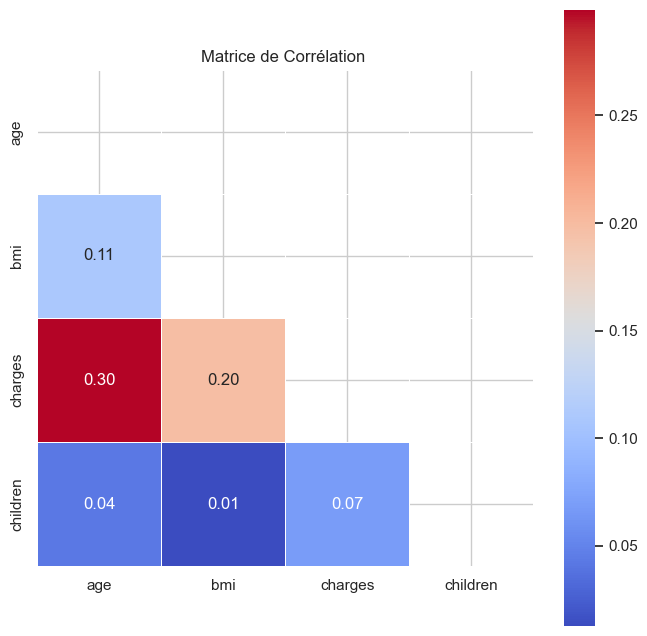

In [44]:
# Calcul de la matrice de corrélation
num_data = data[['age', 'bmi', 'charges', 'children']]
corr = num_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Plot complet sans mask, avec annotations dans chaque case
plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,        # active les annotations
    fmt='.2f',         # format à deux décimales
    cmap='coolwarm',   # palette de couleurs
    linewidths=0.5,    # séparations entre les cases
    square=True        # cases carrées
)
plt.title('Matrice de Corrélation ')
plt.show()

In [45]:
X = data.drop('charges', axis=1)
y = data['charges']

# Encodage des variables catégorielles et standardisation
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['age', 'bmi', 'children']),
    ('cat', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region'])
])

X_processed = preprocessor.fit_transform(X)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [47]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

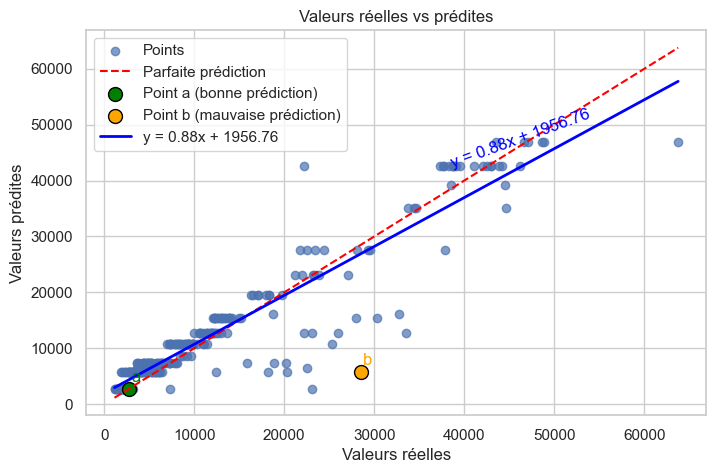

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Comparaison entre les vraies valeurs et les prédictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, label="Points")

# Ligne diagonale y = x (prédiction parfaite)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', label="Parfaite prédiction")

plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Valeurs réelles vs prédites")

# Sélection du point 'a' : prédiction la plus proche
errors = np.abs(y_test - y_pred)
index_a = np.argmin(errors)  # plus petite erreur
index_b = np.argmax(errors)  # plus grande erreur

x_a, y_a = y_test.iloc[index_a], y_pred[index_a]
x_b, y_b = y_test.iloc[index_b], y_pred[index_b]

# Affichage des points 'a' et 'b'
plt.scatter(x_a, y_a, color='green', s=100, edgecolor='black', label="Point a (bonne prédiction)")
plt.annotate("a", (x_a, y_a), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='green')

plt.scatter(x_b, y_b, color='orange', s=100, edgecolor='black', label="Point b (mauvaise prédiction)")
plt.annotate("b", (x_b, y_b), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='orange')

# Calcul de la régression linéaire y_pred ≈ a * y_test + b
a, b = np.polyfit(y_test, y_pred, 1)
x_vals = np.linspace(y_test.min(), y_test.max(), 100)
y_vals = a * x_vals + b

# Tracer la droite de régression
plt.plot(x_vals, y_vals, color='blue', linewidth=2, label=f'y = {a:.2f}x + {b:.2f}')

# Ajouter l'équation y = ax + b sur la figure
plt.text(0.6 * y_test.max(), 0.9 * y_pred.max(), f'y = {a:.2f}x + {b:.2f}', 
         fontsize=12, rotation=20, color='blue')

plt.legend()
plt.show()

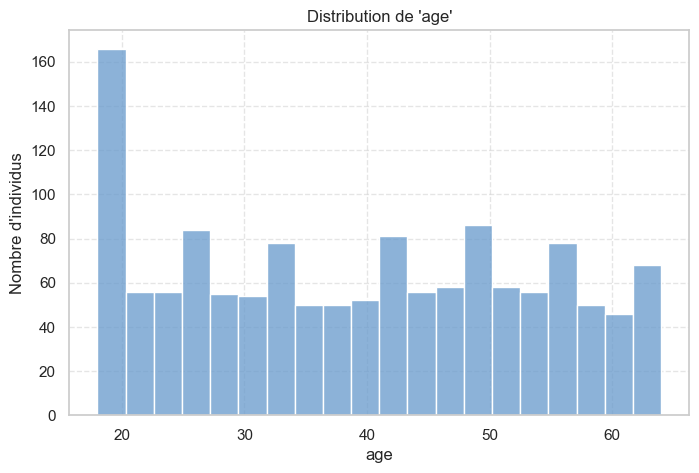

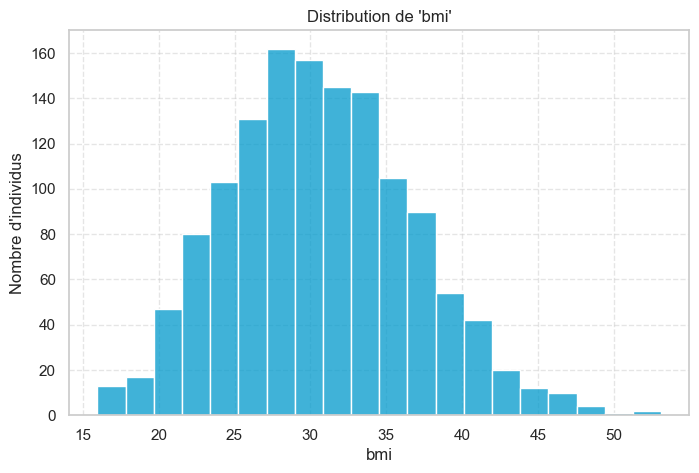

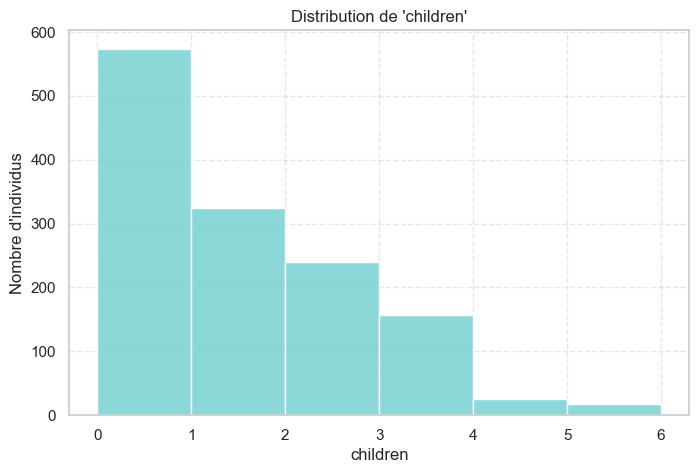

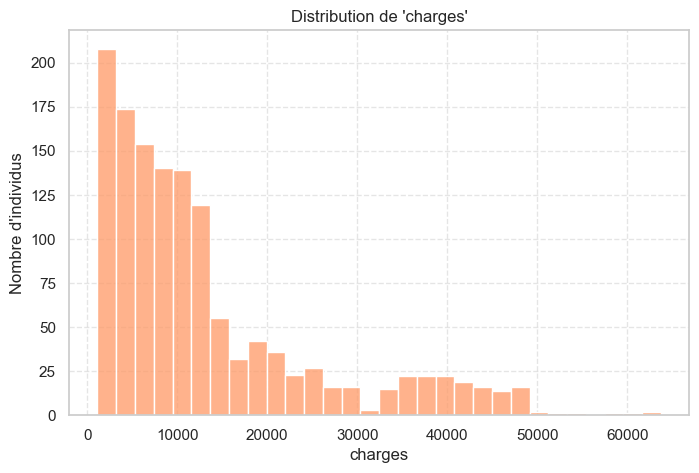

In [49]:
# 2. Numériques : age, bmi, children, charges
plot_hist('age', bins=20, color='#6699cc')
plot_hist('bmi', bins=20, color='#0099cc')
plot_hist('children', bins=range(0, data['children'].max() + 2), color='#66cccc')
plot_hist('charges', bins=30, color='#ff9966')

In [50]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R²: 0.7836
MAE: 4181.19
RMSE: 5796.28


MAE : 2697.77
R² : 0.86


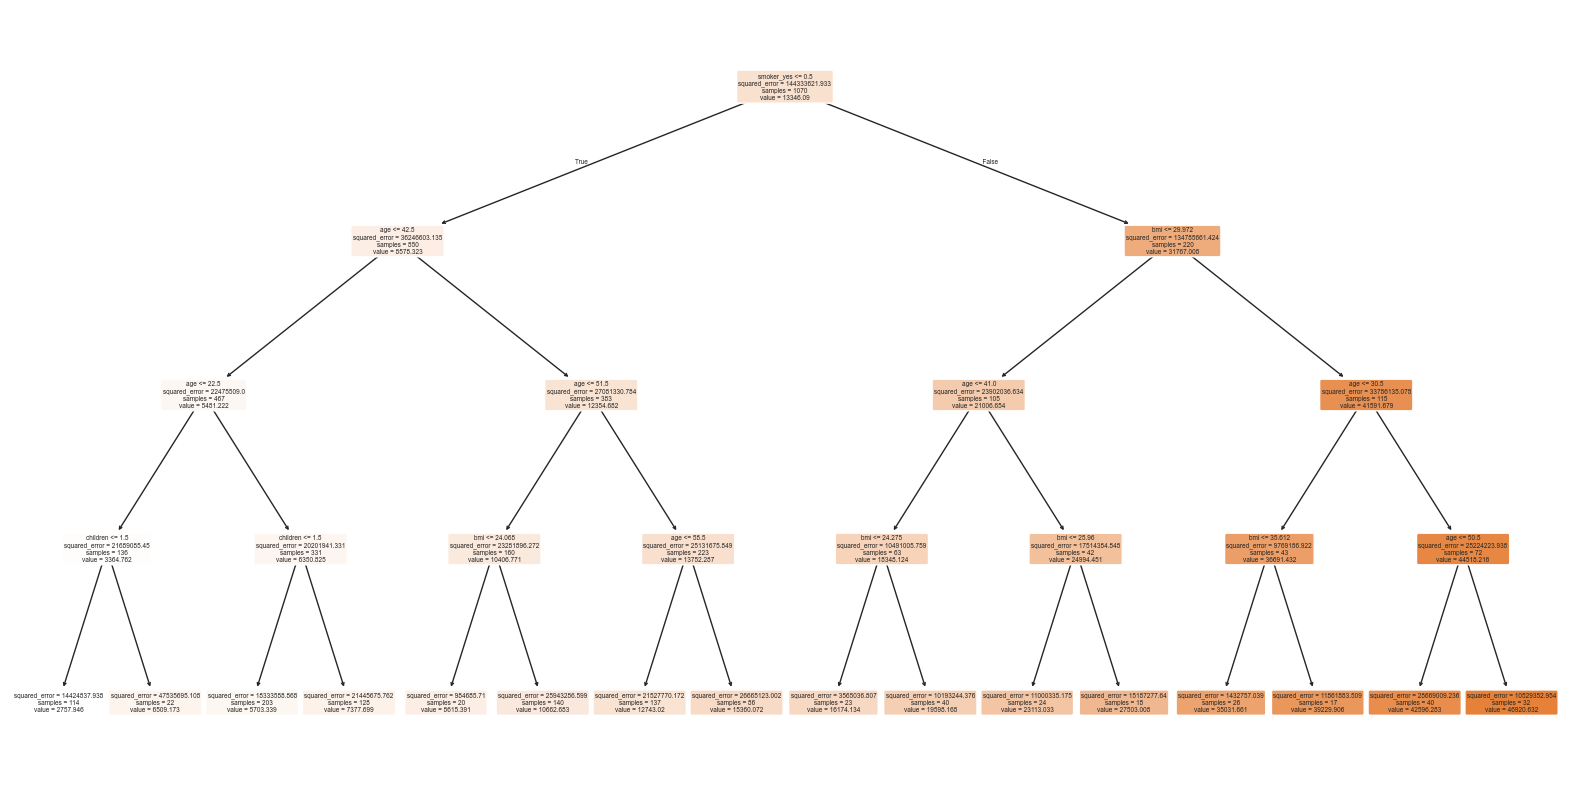

In [51]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Encodage des variables catégorielles
data_encoded = pd.get_dummies(data, drop_first=True)

# Séparation X (features) et y (target)
X = data_encoded.drop('charges', axis=1)
y = data_encoded['charges']

# Division en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle : arbre de décision
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = tree_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"R² : {r2:.2f}")

# Affichage de l’arbre
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.show()